<a href="https://colab.research.google.com/github/PedroPertusi/afd-monitor-jogadores/blob/main/data_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monitor de notícias de jogadores de futebol - Campeonato Brasileiro Série A 2025

## Configuração do Ambiente e Instalação de Dependências

Este notebook utiliza Python e requer a criação de um ambiente virtual para garantir a consistência das dependências. Execute os comandos abaixo no terminal para configurar o ambiente:

```bash
python -m venv venv
source venv/bin/activate  # No Windows: venv\Scripts\activate
pip install --upgrade pip
pip install -r requirements.txt
```

O arquivo `requirements.txt` deve conter todas as bibliotecas necessárias para rodar este notebook.


## Objetivo do Notebook
Este notebook tem como objetivo extrair e analisar notícias de jogadores de futebol do Campeonato Brasileiro Série A 2025, coletando dados do site Globo Esporte e organizando-os em um formato estruturado para análise posterior.

In [1]:
import os
import re
import math

import requests
from bs4 import BeautifulSoup

import nltk
from nltk.corpus import stopwords

import pandas as pd

import wordcloud
import matplotlib.pyplot as plt
from IPython.display import display

from dotenv import load_dotenv

import google.generativeai as genai
from google.generativeai import GenerationConfig


c:\Users\PEDRO PERTUSI\Desktop\afd-monitor-jogadores\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Função para obter o HTML da página a ser acessada para extração dos dados

In [2]:
def baixar_pagina(url):
    """
    Faz uma requisição HTTP GET para a URL fornecida e retorna o conteúdo HTML da página.

    Parâmetros:
    url (str): Endereço da página a ser baixada.

    Retorna:
    str: Conteúdo HTML da página como texto decodificado em UTF-8.
    """
    response = requests.get(url)
    response.encoding = "utf-8"
    return response.text

Função responsável por obter o link de uma notícia contido em seu respectivo título

In [3]:
def extrair_links_noticias_post(url):
    """
    Extrai os links de notícias de um post de página HTML.

    Parâmetros:
    url (str): URL da página a partir da qual serão extraídos os links.

    Retorna:
    List[str]: Lista de URLs obtidas dos elementos <h2><a> encontrados na página.
    """
    html = baixar_pagina(url)
    soup = BeautifulSoup(html, 'html.parser')
    titulos = soup.find_all('h2')
    links_noticias = []
    for titulo in titulos:
        a_tag = titulo.find('a')
        if a_tag and a_tag.get('href'):
            links_noticias.append(a_tag.get('href'))
    return links_noticias


Função para extrair o conteúdo de cada notícia

In [4]:
def extrair_conteudo_noticia(url):
    """
    Extrai o conteúdo textual de uma notícia a partir da URL fornecida,
    filtrando parágrafos relevantes e descartando intertítulos e listas.

    Parâmetros:
    url (str): Endereço da página da notícia a ser processada.

    Retorna:
    List[str]: Lista de strings contendo o texto limpo de cada parágrafo
               (<p> com classe 'content-text__container') sem intertítulos
               (div com classe 'content-intertitle') nem listas (<ul>).
    """
    html = baixar_pagina(url)
    soup = BeautifulSoup(html, 'html.parser')
    ps = soup.find_all('p', class_='content-text__container')

    textos = []
    for p in ps:
        # descarta parágrafos que contenham intertítulo ou lista
        if p.find('div', class_='content-intertitle') or p.find('ul'):
            continue
        # extrai texto limpo (inclui <a>, <strong>, etc)
        textos.append(p.get_text(" ", strip=True))
    return textos

Após a definição das funções necessárias para a extração de dados, podemos aplicá-las para realizar a extração

O site escolhido para a obtenção de notícias foi o Globo Esporte (https://ge.globo.com/)

In [5]:
times = ["atletico-mg", "bahia", "botafogo", "bragantino", "ceara", "corinthians", "cruzeiro", "flamengo", "fluminense", "fortaleza",
         "gremio", "internacional", "juventude", "mirassol", "palmeiras", "santos", "sao-paulo", "sport", "vasco", "vitoria"]

conteudos_times = {}

In [6]:
# Base URL para as páginas de notícias dos times
base_url = "https://ge.globo.com/futebol/times/"

# Para cada time em 'times', extrai e limpa o conteúdo das notícias
for t in times:
    time_url = base_url + t  # URL completa da página do time
    noticias = extrair_links_noticias_post(time_url)  # links dos posts de notícia

    conteudos = []
    for n in noticias:
        # Pula links que não pertencem ao domínio principal
        if not n.startswith("https://ge.globo.com/"):
            continue
        # Adiciona o conteúdo (lista de parágrafos) de cada notícia
        conteudos.append(extrair_conteudo_noticia(n))

    # Padrão para filtrar cabeçalhos automáticos do site (e.g., "+ O ge")
    pattern = re.compile(r'^\+ O ge')
    # Concatena parágrafos e remove entradas que batem com o padrão
    c = [
        " ".join(parts)
        for parts in conteudos
        if not pattern.match(" ".join(parts))
    ]

    # Remove strings vazias ou que contenham apenas espaço em branco
    c = [texto for texto in c if texto.strip()]

    # Armazena o conteúdo limpo no dicionário por time
    conteudos_times[t] = c


In [7]:
# Gera uma lista de tuplas (time, notícia) para todas as notícias de cada time
records = [
    (time, noticia)
    for time, noticias in conteudos_times.items()
    for noticia in noticias
]

# Constrói um DataFrame com colunas 'time' e 'noticia' a partir dos registros
df_time_noticia = pd.DataFrame(records, columns=['time', 'noticia'])


Para verificarmos se a extração foi feita corretamente, vamos exibir o DataFrame construído com os times e suas respectivas notícias.

In [8]:
df_time_noticia

time                                            noticia
0   atletico-mg  A disputa entre Cuiabá e Atlético-MG por valor...
1   atletico-mg  Fala, galera! O time das Dicas Econômicas está...
2   atletico-mg  Atlético-MG e Cienciano entram em campo nesta ...
3   atletico-mg  O meia-atacante Bernard foi a grande novidade ...
4         bahia  Durou dois minutos o sonho do Bahia em avançar...
..          ...                                                ...
84      vitoria  O site do Brasil Escola explica o "déjà-vu" co...
85      vitoria  Mesmo com superioridade numérica desde os 14 m...
86      vitoria  O Vitória sofreu mais um duro golpe na tempora...
87      vitoria  O Vitória foi eliminado da Copa Sul-Americana ...
88      vitoria  O Vitória alcançou o seu principal objetivo pa...

[89 rows x 2 columns]

Após a validação do DataFrame, podemos salvar estas informações dentro de um arquivo .csv no diretório /data

In [9]:
if not os.path.exists('./data'):
    os.makedirs('./data')

In [10]:
df_time_noticia.to_csv("./data/times_noticias.csv")

### Nuvem de Palavras por Time

Esta célula gera nuvens de palavras para cada time de forma resumida:

1. **Stopwords:** Carrega stopwords em português e inclui variações do nome do time e termos comuns de notícias.
2. **Limpeza:** Filtra essas stopwords do texto consolidado de cada time.
3. **Geração:** Cria e plota `WordCloud` (800×400) em um grid com 2 colunas.
4. **Exibição:** Ajusta o layout, esconde eixos extras e exibe as nuvens.

Ideal para identificar rapidamente os termos mais frequentes por time.


[nltk_data] Downloading package stopwords to C:\Users\PEDRO
[nltk_data]     PERTUSI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


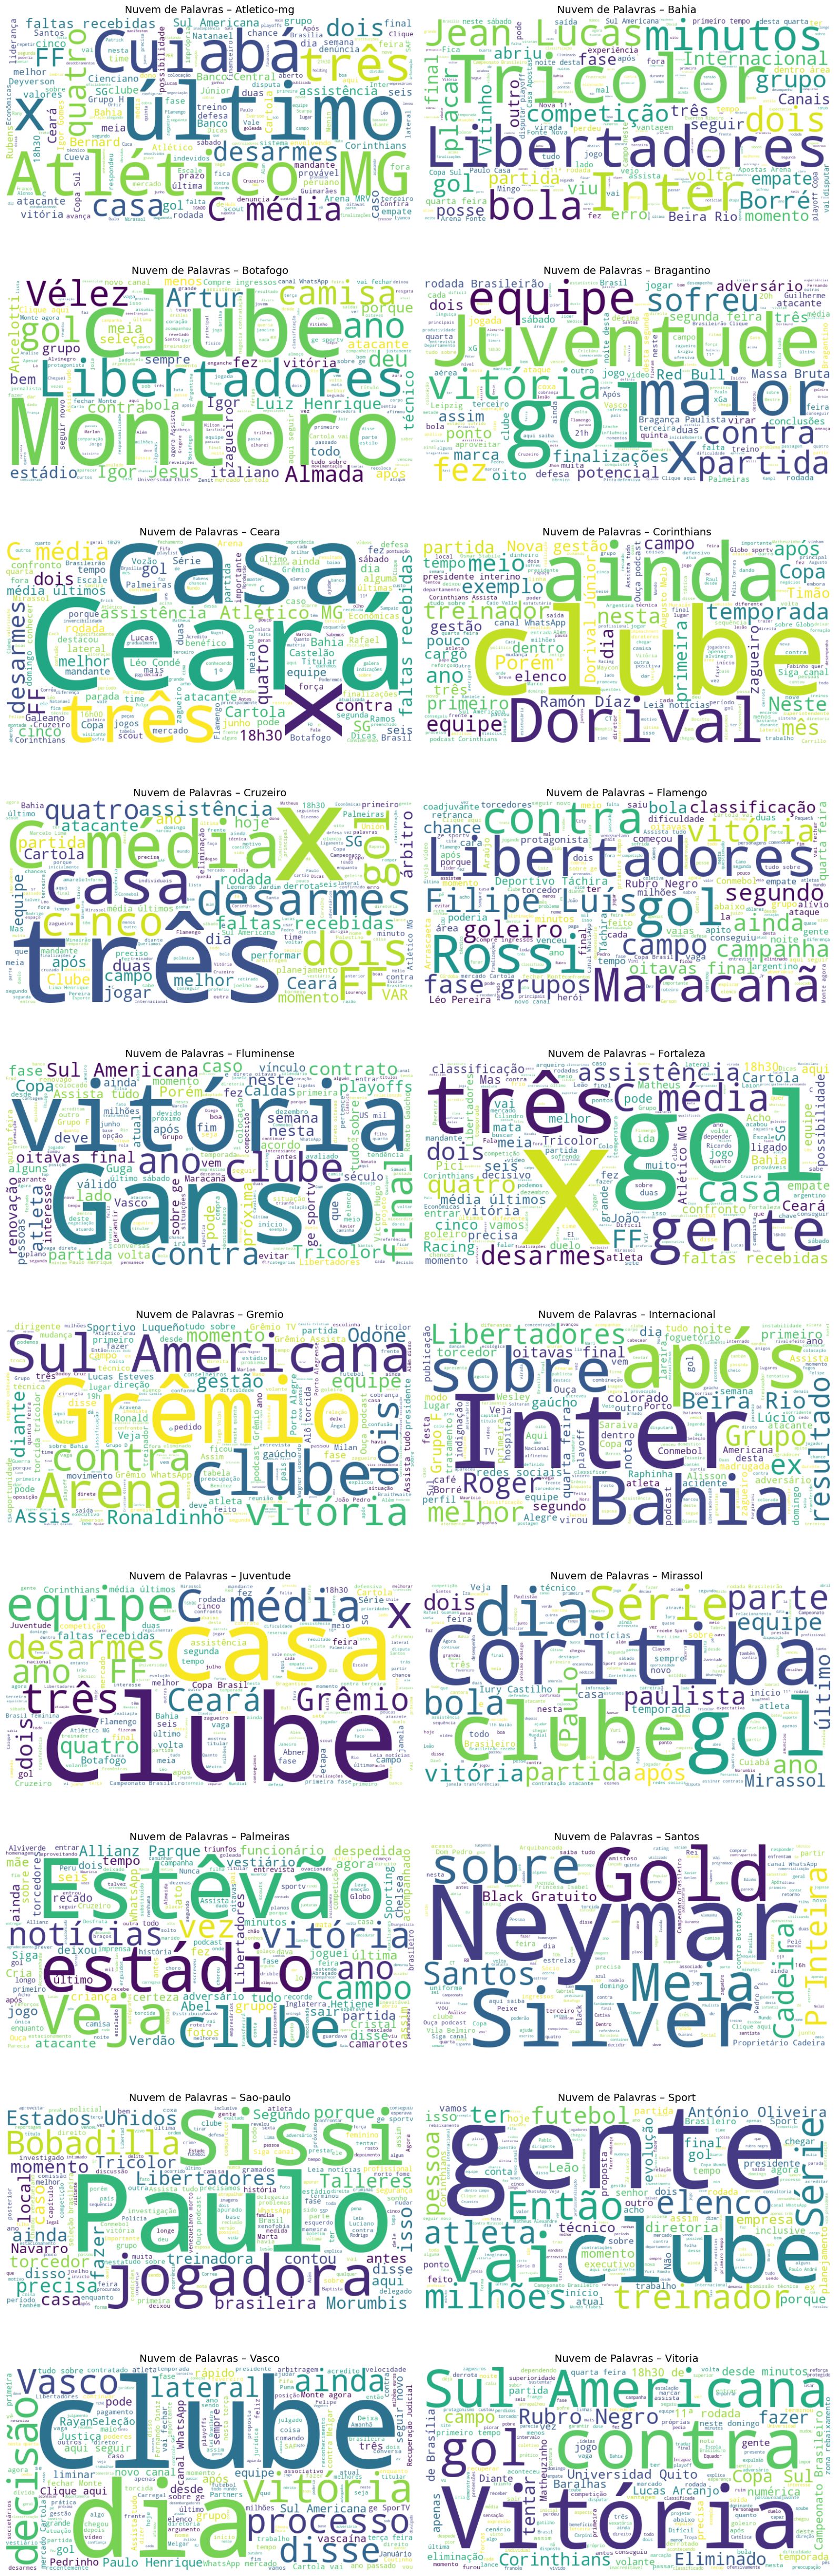

In [11]:
nltk.download('stopwords')

def gerar_nuvens_por_time(conteudos_times):
    """
    Gera e exibe nuvens de palavras para cada time.

    - Filtra stopwords em português e variações do nome do time.
    - Remove termos comuns de notícia e futebol.
    - Plota as nuvens em um grid de 2 colunas.

    Args:
        conteudos_times (dict): mapeia nome do time (str) para lista de textos (List[str]).
    """
    stop_words_base = set(stopwords.words('portuguese'))

    teams = list(conteudos_times.keys())
    cols = 2
    rows = math.ceil(len(teams) / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 5))
    axes = axes.flatten()

    for idx, time in enumerate(teams):
        # Une todos os textos do time em uma única string
        texto = " ".join(conteudos_times[time])

        # Inclui variações do nome do time nas stopwords
        extras = {time, time.replace('-', ''), time.replace('-', ' ')}
        stop_words = stop_words_base.union(w.lower() for w in extras)
        stop_words.update([
            'ge', 'g1', 'globo', 'globoesporte', 'futebol',
            'brasileirao', 'brasileirão', 'notícia', 'noticias',
            'jogo', 'jogos', 'time', 'times', 'jogador', 'jogadores'
        ])

        # Filtra palavras indesejadas
        palavras = [w for w in texto.split() if w.lower() not in stop_words]
        texto_limpo = " ".join(palavras)

        # Gera a nuvem de palavras
        wc = wordcloud.WordCloud(width=800, height=400, background_color='white')
        wc.generate(texto_limpo)

        # Exibe a nuvem
        ax = axes[idx]
        ax.imshow(wc, interpolation='bilinear')
        ax.axis('off')
        ax.set_title(f'Nuvem de Palavras – {time.capitalize()}', fontsize=14)

    # Desliga eixos extras se houver subplots sobrando
    for ax in axes[len(teams):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Executa a geração de nuvens
gerar_nuvens_por_time(conteudos_times)


# Classificador de Sentimentos 

### Configuração do Gemini e Técnica de Few-Shot Learning

Para usar o modelo Gemini, é necessário criar um arquivo `.env` na raiz do projeto contendo sua chave de API:

```
GEMINI_API_KEY=your_api_key_here
```

Este parte do notebook utiliza a técnica de *few-shot learning* para classificação de sentimento. A abordagem consiste em:

1. **Exemplos de Apoio**: Carregar um CSV (`few_shot_examples.csv`) com alguns exemplos rotulados de texto e sentimento.
2. **Construção do Prompt**: Combinar os exemplos de apoio com os novos textos a serem classificados em um único prompt.
3. **Chamada à LLM**: Enviar o prompt ao modelo Gemini para que ele aprenda, a partir dos exemplos, como classificar o sentimento dos novos textos.
4. **Interpretação da Resposta**: O modelo retorna uma lista de pares `ID: SENTIMENTO`, que é então mapeada de volta ao DataFrame original.

Essa técnica permite orientar o modelo com exemplos personalizados sem a necessidade de treinar um novo modelo do zero.


In [12]:
# Carrega variáveis de ambiente do arquivo .env
load_dotenv()

# Configura a chave de API para acessar o modelo Gemini
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

# Instancia o modelo generativo Gemini 1.5-flash
model = genai.GenerativeModel(model_name="gemini-1.5-flash")

# Caminho do CSV com as notícias dos times
csv_path = './data/times_noticias.csv'

# Carrega o arquivo CSV em um DataFrame
df = pd.read_csv(csv_path)

# Inicializa (ou preserva) a coluna 'sentiment' para armazenar classificações
df['sentiment'] = df.get('sentiment', None)


In [13]:
# Carrega DataFrame de exemplos few-shot
example_df = pd.read_csv('./data/few_shot_examples.csv')  # colunas: id, noticia, sentiment

# Ajusta DataFrame principal (df) já carregado a partir de times_noticias.csv
# Renomeia coluna de índice não nomeada para 'id', se existir
if 'Unnamed: 0' in df.columns:
    df = df.rename(columns={'Unnamed: 0': 'id'})
# Se ainda não houver coluna 'id', cria-a a partir do índice
if 'id' not in df.columns:
    df['id'] = df.index

# 1. Constrói o bloco de exemplos few-shot
few_shot = ""
for _, ex in example_df.iterrows():
    eid, text, label = ex['id'], ex['noticia'], ex['sentiment']
    few_shot += f'Texto (ID {eid}): "{text}"\nSentimento: {label}\n\n'

# 2. Seleciona somente as notícias que serão classificadas (exclui exemplos few-shot)
batch_items = df[~df['id'].isin(example_df['id'])]

# 3. Prepara a lista de itens no formato "ID: \"noticia\""
batch_list = "\n".join(
    f"{row['id']}: \"{row['noticia']}\""
    for _, row in batch_items.iterrows()
)

# 4. Monta o prompt completo para enviar ao modelo
batch_prompt = (
    few_shot
    + "Agora, para cada um dos textos abaixo, identifique o sentimento como 'positive', 'neutral' ou 'negative'.\n"
    + "Responda em formato de lista, uma linha por item, no formato:\n"
    + "ID: SENTIMENTO\n\n"
    + batch_list
)


In [ ]:
# Configura parâmetros de geração para o Gemini
generation_config = GenerationConfig(
    max_output_tokens=len(batch_items) * 5,  # define limite de tokens com base na quantidade de itens
    temperature=0.0                          # temperatura zero garante saída determinística
)

# Envia o prompt ao modelo e obtém a resposta
response = model.generate_content(
    batch_prompt,
    generation_config=generation_config
)


In [ ]:
# Inicializa dicionário para armazenar mapeamento ID → sentimento
mapping = {}

# Percorre cada linha da resposta gerada pelo modelo
for line in response.text.splitlines():
    # Captura linhas no formato "ID: sentimento" ou "ID - sentimento"
    match = re.match(
        r'^\s*(\d+)\s*[:\-]\s*(positive|neutral|negative)',
        line.strip(),
        re.IGNORECASE
    )
    if match:
        # Extrai ID como inteiro e sentimento em lowercase
        item_id = int(match.group(1))
        sentiment = match.group(2).lower()
        mapping[item_id] = sentiment

# Atualiza o DataFrame original, atribuindo o sentimento conforme o mapeamento
for eid, sentiment in mapping.items():
    df.loc[df['id'] == eid, 'sentiment'] = sentiment

# Salva o DataFrame classificado em um novo arquivo CSV
output_path = './data/times_noticias_classified.csv'
df.to_csv(output_path, index=False)
print(f"Classificação salva em: {output_path}")


Classificação salva em: ./data/times_noticias_classified.csv


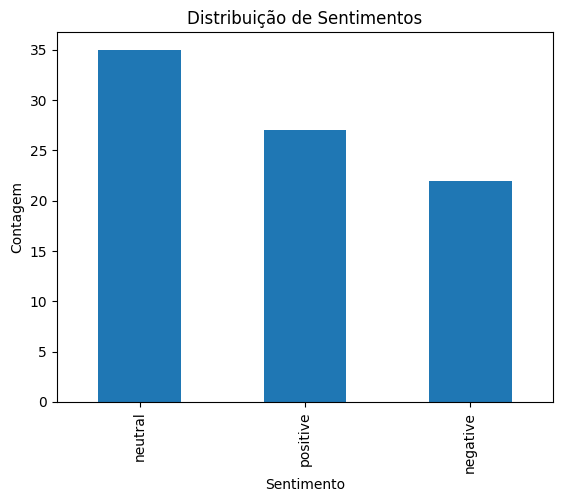

In [ ]:
# Conta a frequência de cada categoria de sentimento
sentiment_counts = df['sentiment'].value_counts()

# Plota um gráfico de barras para a distribuição de sentimentos
sentiment_counts.plot(
    kind='bar',
    title='Distribuição de Sentimentos'
)

# Define rótulos para os eixos
plt.xlabel('Sentimento')
plt.ylabel('Contagem')

# Exibe o gráfico na tela
plt.show()


In [ ]:
# Ajusta pandas para exibir conteúdo completo das células
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)

# Carrega o DataFrame classificado
df_classified = pd.read_csv('./data/times_noticias_classified.csv')

# Renomeia coluna de índice se ainda existir como 'Unnamed: 0'
if 'Unnamed: 0' in df_classified.columns:
    df_classified = df_classified.rename(columns={'Unnamed: 0': 'id'})

# Seleciona 2 notícias aleatórias para cada sentimento
sampled_df = (
    df_classified
      .groupby('sentiment')
      .apply(lambda grp: grp.sample(2))
      .reset_index(drop=True)
)

# Remove eventuais colunas residuais que começam com 'Unnamed'
sampled_df = sampled_df.drop(
    columns=[c for c in sampled_df.columns if c.startswith('Unnamed')],
    errors='ignore'
)

# Exibe a amostra completa em formato de tabela interativa
display(sampled_df)


C:\Users\PEDRO PERTUSI\AppData\Local\Temp\ipykernel_36184\2178692426.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(2))


id       time  \
0  74      sport   
1  75      sport   
2  55  juventude   
3  29   cruzeiro   
4  59   mirassol   
5  57   mirassol   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

### Conclusão

Neste notebook construímos um fluxo completo de extração, classificação e visualização de sentimentos em notícias:

1. **Extração de Dados**  
   - Baixamos e parseamos páginas de notícia com `requests` e `BeautifulSoup`.  
   - Coletamos títulos e parágrafos relevantes para gerar um DataFrame limpo.  

2. **Visualização: Nuvens de Palavras por Time**  
   - Definimos stopwords em português e incluímos variações do nome de cada time.  
   - Limpeza de texto e geração de `WordCloud` em um layout de 2 colunas.  
   - Permitimos identificar, de forma intuitiva, os termos mais frequentes em cada conjunto de notícias.  

3. **Classificação Few-Shot com Gemini**  
   - Configuramos o `.env` com `GEMINI_API_KEY`.  
   - Utilizamos um conjunto de exemplos rotulados (`few_shot_examples.csv`) para guiar o modelo em um prompt customizado.  
   - Classificamos cada texto em “positivo”, “neutro” ou “negativo” sem necessidade de treinar um modelo do zero.  

4. **Documentação e Legibilidade**  
   - Seções em Markdown introduzem e explicam cada etapa do pipeline.  
   - Docstrings e comentários em células de código descrevem parâmetros, lógica e entradas/saídas de funções.  
   - Instruções de setup garantem reprodutibilidade do ambiente.

**Próximos Passos**  
- Refinar a lista de exemplos few-shot para melhorar a precisão da classificação.  
- Explorar outras formas de visualização (gráficos de barra, séries temporais).  
- Refinar a coleta de notícias, explorando para outros sites e outros tipos de limpeza de dados

Com isso, o notebook está pronto para uso e serve como base clara e documentada para futuras evoluções do projeto.  
